In [3]:
import numpy as np
import pandas as pd
from datetime import timedelta

%matplotlib inline
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)

In [45]:
from scipy.optimize import curve_fit

In [365]:
!wget https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv

--2020-03-23 12:31:48--  https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv
Resolving raw.githubusercontent.com... 151.101.132.133
Connecting to raw.githubusercontent.com|151.101.132.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 53277 (52K) [text/plain]
Saving to: ‘dpc-covid19-ita-regioni.csv’

dpc-covid19-ita-reg 100%[===================>]  52.03K  --.-KB/s    in 0.03s   

2020-03-23 12:31:49 (1.78 MB/s) - ‘dpc-covid19-ita-regioni.csv’ saved [53277/53277]



In [366]:
data = pd.read_csv('dpc-covid19-ita-regioni.csv')

In [367]:
!rm dpc-covid19-ita-regioni.csv

In [302]:
data.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_attualmente_positivi,nuovi_attualmente_positivi,dimessi_guariti,deceduti,totale_casi,tamponi
0,2020-02-24 18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,0,0,0,0,0,5
1,2020-02-24 18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,0,0,0,0,0,0
2,2020-02-24 18:00:00,ITA,4,P.A. Bolzano,46.499335,11.356624,0,0,0,0,0,0,0,0,0,1
3,2020-02-24 18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,0,0,0,0,0,1
4,2020-02-24 18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,0,0,0,0,0,10


In [179]:
def func_exp(x, a, c, d):# = 0):#, d):
    return a*np.exp(-c*x)+d

def func_line(x,m,b):
    return m*x + b

Assumption is exponential growth with varying time scale (default = looking at each week).

In [398]:
def analyze_region(name, data, nchunks = 4, dailies = True):
    
    dp = data[data['denominazione_regione'] == name]
        
    # fit different weeks
    
    for i in range(nchunks):

        cases = np.array_split(dp.totale_casi.values, nchunks)[i]
        days = np.array_split(range(len(dp.totale_casi)), nchunks)[i]
        
    #    popt, pcov = curve_fit(func_exp, days, cases, p0=(1, 1e-6, 1))
    
    #   Fix n_0 at initial value for each week
    
        popt, pcov = curve_fit(lambda x, a, c: func_exp(x, a, c, cases.min() - a*np.exp(-c*days.min())) , days, cases, p0=(1, 1e-2))
        
 #       print('Fit params', np.round(popt, 3))

        print('Date range, chunk', i,': ', np.min(np.array_split(dp.data.values, nchunks)[i]), \
              np.max(np.array_split(dp.data.values, nchunks)[i]))
    
        print('Doubling time for new cases, chunk', i,': ', np.round(np.log(2)/-popt[1], 3), 'days')
    
        print('r2 score, chunk', i,': ', np.round(r2_score(cases, func_exp(days, *popt, cases.min() - popt[0]*np.exp(-popt[1]*days.min()))), 3))
    
    #plot cases
    
    plt.figure(figsize=(14,7))
    plt.title('Statistics, region: '+str(name), fontsize = 14)
    plt.plot(dp.data, dp.totale_casi,'o-', label = 'Total new cases')
    plt.plot(dp.data, dp.dimessi_guariti,'o-', c = 'g', label = 'Recovered')
    plt.plot(dp.data, dp.deceduti,'o-', c ='r', label = 'Deceased')
    percent_test = (dp.totale_casi/dp.tamponi).values
    plt.bar(dp.data[4:],percent_test[4:], alpha = 0.5, label = '% positive tests') #to avoid zero
    ax=plt.gca()
    for i in range(4, len(percent_test)):
            ax.annotate(str(np.round(100*percent_test[i], 1)), (i-0.3, percent_test[i]*1.1), clip_on = True)
            
    if (dailies):
        dailies = np.array([dp.totale_casi.iloc[i] - dp. totale_casi.iloc[i-1] \
                                                      for i in range(1,len(dp.totale_casi))])
        plt.bar(np.arange(1,len(dp.totale_casi)), dailies, alpha = 0.5, label = 'New daily cases')
       
        ax=plt.gca()
        
        for i in range(len(dailies)):

            ax.annotate(str(dailies[i]), (i+0.7, dailies[i]*1.1), clip_on = True)# + 0.1*np.log(dailies[i])))
        
    plt.yscale('log')
    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 70, 'ha', 'right');
    plt.tick_params(axis='y', which='both', labelleft=True, labelright=True)

    plt.legend()
    
    
     
        

Date range, chunk 0 :  2020-02-24 18:00:00 2020-03-01 17:00:00
Doubling time for new cases, chunk 0 :  4.949 days
r2 score, chunk 0 :  0.825
Date range, chunk 1 :  2020-03-02 18:00:00 2020-03-08 18:00:00
Doubling time for new cases, chunk 1 :  1.765 days
r2 score, chunk 1 :  0.995
Date range, chunk 2 :  2020-03-09 18:00:00 2020-03-15 17:00:00
Doubling time for new cases, chunk 2 :  2.144 days
r2 score, chunk 2 :  0.998
Date range, chunk 3 :  2020-03-16 17:00:00 2020-03-22 17:00:00
Doubling time for new cases, chunk 3 :  12.695 days
r2 score, chunk 3 :  0.995


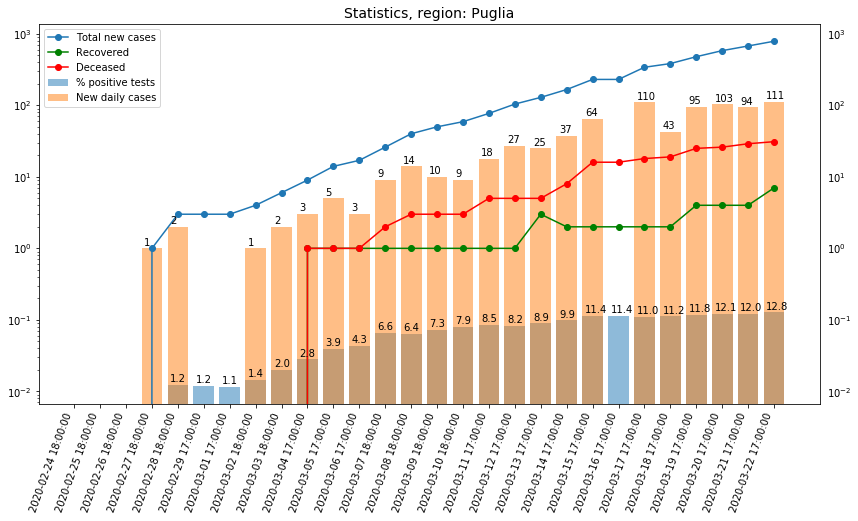

In [399]:
analyze_region('Puglia', data)

Date range, chunk 0 :  2020-02-24 18:00:00 2020-03-01 17:00:00
Doubling time for new cases, chunk 0 :  1.89 days
r2 score, chunk 0 :  0.981
Date range, chunk 1 :  2020-03-02 18:00:00 2020-03-08 18:00:00
Doubling time for new cases, chunk 1 :  2.815 days
r2 score, chunk 1 :  0.998
Date range, chunk 2 :  2020-03-09 18:00:00 2020-03-15 17:00:00
Doubling time for new cases, chunk 2 :  4.379 days
r2 score, chunk 2 :  0.992
Date range, chunk 3 :  2020-03-16 17:00:00 2020-03-22 17:00:00
Doubling time for new cases, chunk 3 :  6.171 days
r2 score, chunk 3 :  0.994


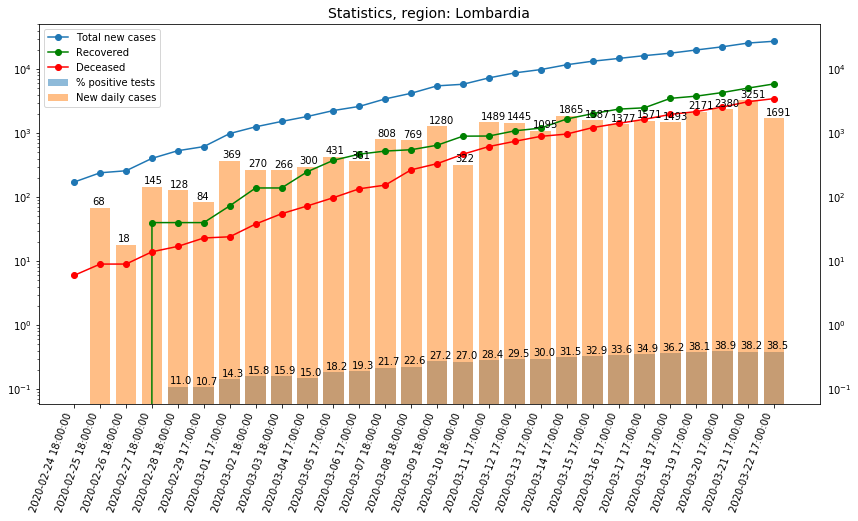

In [392]:
analyze_region('Lombardia', data)

Date range, chunk 0 :  2020-02-24 18:00:00 2020-03-01 17:00:00
Doubling time for new cases, chunk 0 :  2.737 days
r2 score, chunk 0 :  0.996
Date range, chunk 1 :  2020-03-02 18:00:00 2020-03-08 18:00:00
Doubling time for new cases, chunk 1 :  3.33 days
r2 score, chunk 1 :  0.996
Date range, chunk 2 :  2020-03-09 18:00:00 2020-03-15 17:00:00
Doubling time for new cases, chunk 2 :  5.152 days
r2 score, chunk 2 :  0.99
Date range, chunk 3 :  2020-03-16 17:00:00 2020-03-22 17:00:00
Doubling time for new cases, chunk 3 :  5.28 days
r2 score, chunk 3 :  0.996


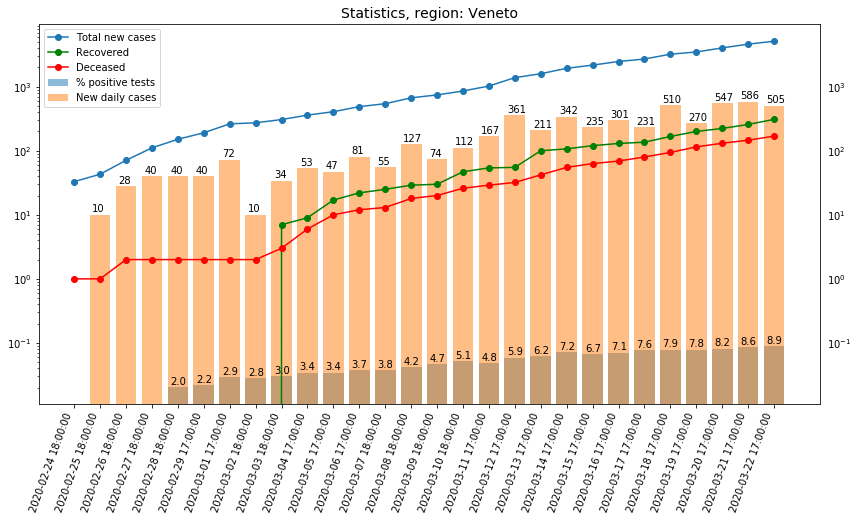

In [400]:
analyze_region('Veneto', data)

Date range, chunk 0 :  2020-02-24 18:00:00 2020-03-01 17:00:00
Doubling time for new cases, chunk 0 :  2.678 days
r2 score, chunk 0 :  0.936
Date range, chunk 1 :  2020-03-02 18:00:00 2020-03-08 18:00:00
Doubling time for new cases, chunk 1 :  2.204 days
r2 score, chunk 1 :  0.996
Date range, chunk 2 :  2020-03-09 18:00:00 2020-03-15 17:00:00
Doubling time for new cases, chunk 2 :  2.46 days
r2 score, chunk 2 :  0.996
Date range, chunk 3 :  2020-03-16 17:00:00 2020-03-22 17:00:00
Doubling time for new cases, chunk 3 :  15.151 days
r2 score, chunk 3 :  0.997


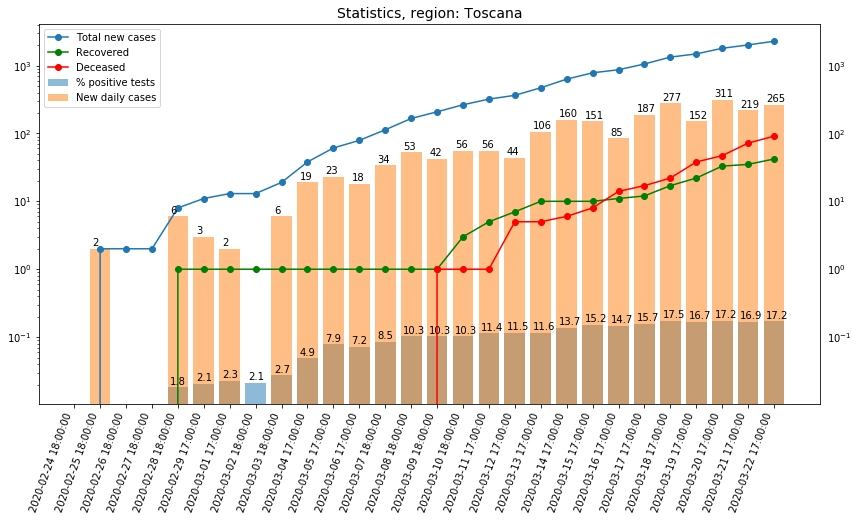

In [401]:
analyze_region('Toscana', data)

Date range, chunk 0 :  2020-02-24 18:00:00 2020-03-01 17:00:00
Doubling time for new cases, chunk 0 :  1.084 days
r2 score, chunk 0 :  0.788
Date range, chunk 1 :  2020-03-02 18:00:00 2020-03-08 18:00:00
Doubling time for new cases, chunk 1 :  7.799 days
r2 score, chunk 1 :  0.992
Date range, chunk 2 :  2020-03-09 18:00:00 2020-03-15 17:00:00
Doubling time for new cases, chunk 2 :  2.571 days
r2 score, chunk 2 :  0.993
Date range, chunk 3 :  2020-03-16 17:00:00 2020-03-22 17:00:00
Doubling time for new cases, chunk 3 :  3.951 days
r2 score, chunk 3 :  0.998


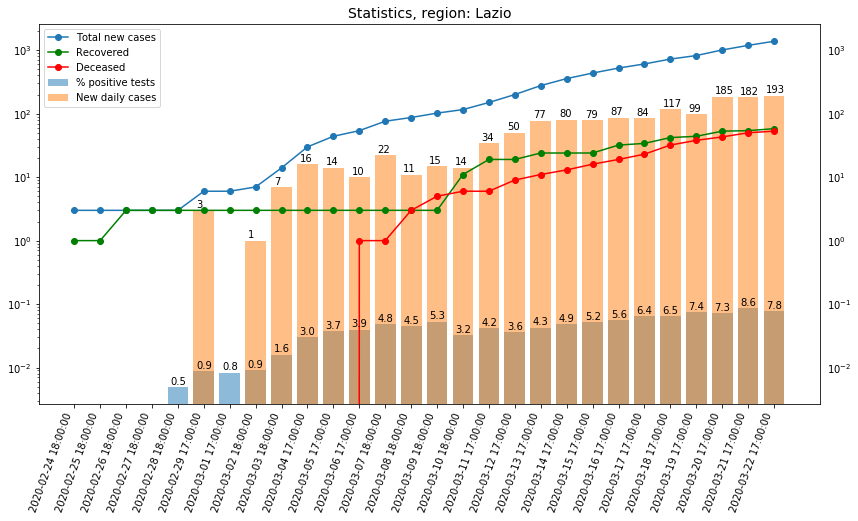

In [402]:
analyze_region('Lazio', data)

Date range, chunk 0 :  2020-02-24 18:00:00 2020-03-01 17:00:00
Doubling time for new cases, chunk 0 :  2.246 days
r2 score, chunk 0 :  0.992
Date range, chunk 1 :  2020-03-02 18:00:00 2020-03-08 18:00:00
Doubling time for new cases, chunk 1 :  6.707 days
r2 score, chunk 1 :  0.997
Date range, chunk 2 :  2020-03-09 18:00:00 2020-03-15 17:00:00
Doubling time for new cases, chunk 2 :  3.09 days
r2 score, chunk 2 :  1.0
Date range, chunk 3 :  2020-03-16 17:00:00 2020-03-22 17:00:00
Doubling time for new cases, chunk 3 :  5.937 days
r2 score, chunk 3 :  0.999


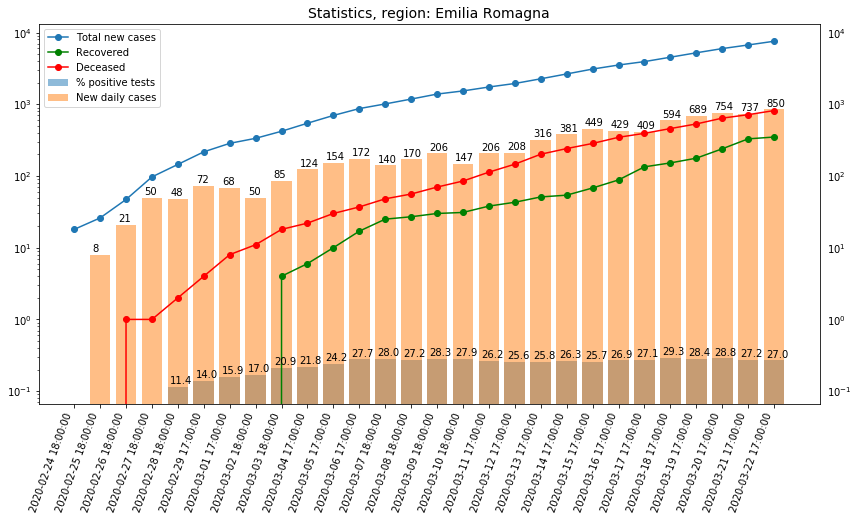

In [403]:
analyze_region('Emilia Romagna', data)

Date range, chunk 0 :  2020-02-24 18:00:00 2020-03-01 17:00:00
Doubling time for new cases, chunk 0 :  0.509 days
r2 score, chunk 0 :  0.972
Date range, chunk 1 :  2020-03-02 18:00:00 2020-03-08 18:00:00
Doubling time for new cases, chunk 1 :  1.225 days
r2 score, chunk 1 :  0.995
Date range, chunk 2 :  2020-03-09 18:00:00 2020-03-15 17:00:00
Doubling time for new cases, chunk 2 :  3.881 days
r2 score, chunk 2 :  0.974
Date range, chunk 3 :  2020-03-16 17:00:00 2020-03-22 17:00:00
Doubling time for new cases, chunk 3 :  18.621 days
r2 score, chunk 3 :  0.995


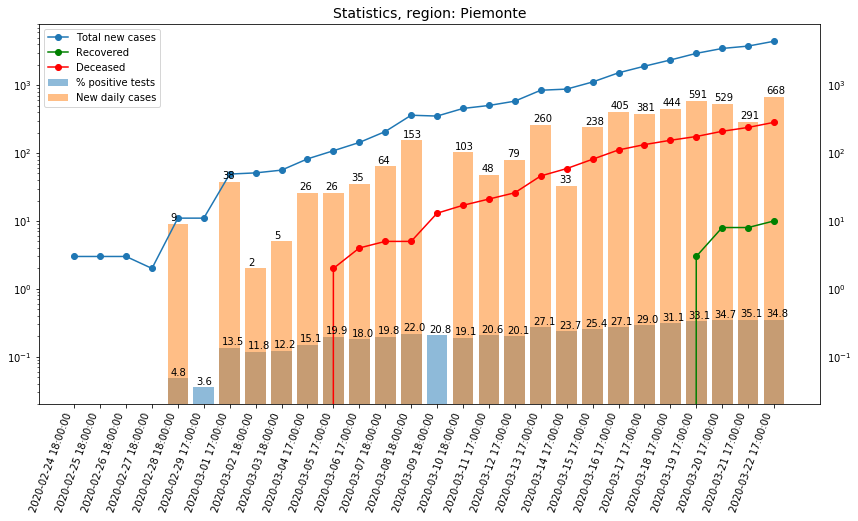

In [404]:
analyze_region('Piemonte', data)